<a href="https://colab.research.google.com/github/antoinexp/Ph.D/blob/master/Spiked_Wigner_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init and Packages

In [1]:
#@title 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from IPython import display

print(tf.test.gpu_device_name())
tf.device('/device:GPU:0')

/device:GPU:0


# Model Implemetation

In [0]:
class Model(tf.Module):
  def __init__(self, a0=0.1, N=100, _lambda=100.):
    self._N = N
    self._lambda = _lambda

    COV = tf.constant([[1.0, a0], [a0, 1.0]])
    A = tf.linalg.cholesky(COV)
    Z = tf.random.normal((2,N,))
    Z = tf.tensordot(A, Z, 1)
    Z = (N**0.5)*tf.math.l2_normalize(Z, axis=1)
    #print(tf.tensordot(Z, tf.transpose(Z), 1).numpy()/N)
    self._theta_star = tf.constant(Z[0,:])
    self._theta = tf.Variable(Z[1,:])

    TMP = tf.random.normal((N,N))
    self._Xi = tf.constant( (TMP + tf.transpose(TMP))/(2.**0.5) )

  @tf.function
  def __call__(self):
    return tf.tensordot(self._theta, self._theta, 0)

  @tf.function
  def eigenvalues(self):
    e, v = tf.linalg.eigh(self.Y())
    tf.print(e)

  @tf.function
  def Y(self):
    signal = tf.tensordot(self._theta_star, self._theta_star, 0)
    noise = ((self._N/self._lambda)**0.5)*self._Xi
    return signal + noise

  @tf.function
  def MSE(self):
    error = self.Y()-self()
    return (1./self._N**2.)*tf.norm(error)**2.

  @tf.function
  def q0(self):
    return (1./self._N)*tf.tensordot(self._theta, self._theta_star, 1)

  @tf.function
  def learn(self, dt):
    grad = tf.gradients(self.MSE(), self._theta)[0]
    surfgrad = grad - (1./self._N)*tf.tensordot(grad, self._theta, 1)*self._theta
    theta_new = self._theta - dt*self._N*(1./4.)*surfgrad
    theta_new = (self._N**0.5)*tf.math.l2_normalize(theta_new)
    self._theta.assign(theta_new)
    return self.q0()
  


# Experiments

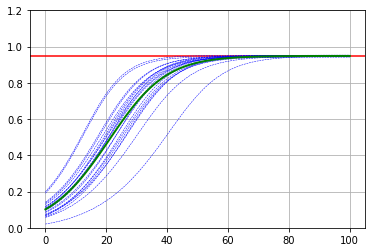

In [15]:
#@title Experiment
_lambda = 10. #@param {type:"number"}
N = 1000 #@param {type:"integer"}
a0 = 0.1 #@param {type:"number"}
dt=0.1 #@param {type:"number"}
steps = 100 #@param {type:"integer"}
N_samples = 20 #@param {type:"integer"}
plt.axhline(y=np.sqrt(1-1./_lambda), color='r', linestyle='-', label="max theoritical")
plt.ylim(0,1.2)
plt.grid(True)

t = np.array([0.]*(steps+1))

for _ in range(N_samples):
  model = Model(a0=a0, N=N, _lambda=_lambda)
  print(abs(model.q0().numpy()))
  l = [abs(model.q0())]
  for _ in range(steps):
    v = model.learn(dt).numpy()
    l.append(abs(v))
  t += np.asarray(l)
  plt.plot(l, "b--", linewidth=0.5)
  display.clear_output(wait=True)
  display.display(plt.gcf())

t /= N_samples
plt.plot(t, "g", linewidth=2)

display.clear_output(wait=True)